In [1]:
from pathlib import Path
from keras.datasets import mnist


import tensorflow as tf


2025-11-07 11:31:09.494749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762543869.587370  807841 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762543869.614832  807841 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762543869.815851  807841 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762543869.815922  807841 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762543869.815924  807841 computation_placer.cc:177] computation placer alr

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Access

In [3]:
data_dir = Path("..","data")
models_dir = Path("..","models")

(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

## Defining Bench Mark Function

In [4]:
import time

def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        print(f"---- Epoch {epoch_num} ----")
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)

        print(f"Execution time for epoch {epoch_num} : {time.perf_counter() - start_time}")
    print("Total Execution time:", time.perf_counter() - start_time)

* So single epoch took 2857.236867081 seconds so ~47 mins mamjority of that time went to data generation since we spent only 0.01s perbatch for "training"

## Data Generation With Tensor Flow

In [5]:
ALL_MNIST_DATA_PIXELS_TF = tf.constant(x_train, dtype=tf.float32)
ALL_MNIST_DATA_CLASSES_TF = tf.constant(y_train, dtype=tf.float32)

# number of digits to overlay on canvas
num_of_digits = tf.constant(3, dtype=tf.int32)

# max digits to define the shape of prediction output
MAX_DIGITS = tf.constant(5, dtype=tf.int32)


# Sample Base Digits
@tf.function
def get_sample_indices(dataset, size=5):
    dataset_len = tf.shape(dataset)[0] - 1
    random_indices = tf.random.uniform(
        shape=[size], minval=0, maxval=dataset_len, dtype=tf.int32)
    return random_indices


@tf.function
def sample_base_digits(num_of_digits):
    """
    Sample a specified number of digit images and their class labels from the master MNIST dataset.

    Args:
        num_of_digits (int): Number of digit samples to retrieve.

    Returns:
        tuple: (sample_pixels, sample_values)
            sample_pixels (np.ndarray): Array of digit images with shape (num_of_digits, 28, 28, 1).
            sample_values (np.ndarray): Array of class labels with shape (num_of_digits, 1).
    """
    sample_indices = get_sample_indices(
        ALL_MNIST_DATA_CLASSES_TF, size=num_of_digits)
    sample_pixels = tf.gather(ALL_MNIST_DATA_PIXELS_TF,
                              indices=sample_indices, axis=0, batch_dims=1)
    sample_pixels = tf.reshape(sample_pixels, shape=(num_of_digits, 28, 28, 1))

    sample_values = tf.gather(
        ALL_MNIST_DATA_CLASSES_TF, indices=sample_indices, axis=0, batch_dims=1)
    sample_values = tf.reshape(sample_values, shape=(num_of_digits, 1))
    return sample_pixels, sample_values


augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomTranslation(
        height_factor=0.2, width_factor=0.2, fill_value=0.0, fill_mode="constant", seed=42),

    tf.keras.layers.RandomZoom(
        height_factor=0.2, width_factor=0.2, fill_value=0.0, fill_mode="constant", seed=42),

    tf.keras.layers.RandomRotation(
        factor=0.1, fill_value=0.0, fill_mode="constant", seed=42),
])


def augment_digits(digits):
    """
    Apply random augmentations (translation, zoom, rotation) to a batch of digit images.

    Args:
        digits (np.ndarray): Array of digit images to augment.
        debug (bool, optional): If True, displays before/after images for each digit. Defaults to False.

    Returns:
        np.ndarray: Augmented digit images as a numpy array.
    """
    # step 2: apply random augmentation
    augmented_tensor_digits = augmentation(digits)
    return augmented_tensor_digits


@tf.function
def get_min_max(active_rows, active_cols):
    # find x_min, x_max
    # step 1 find indices for active x
    non_zero_active_cols = tf.where(active_cols != 0)
    # get the first and last active x as x_min and x_max
    x_min = tf.cast(tf.reduce_min(non_zero_active_cols[:, 1]), dtype=tf.int32)
    x_max = tf.cast(tf.reduce_max(non_zero_active_cols[:, 1]), dtype=tf.int32)

    ##
    non_zero_active_rows = tf.where(active_rows != 0)
    y_min = tf.cast(tf.reduce_min(non_zero_active_rows[:, 0]), dtype=tf.int32)
    y_max = tf.cast(tf.reduce_max(non_zero_active_rows[:, 0]), dtype=tf.int32)

    return x_min, x_max, y_min, y_max


@tf.function
def create_blank_canvas(shape=(100, 100, 1)):
    """
    Create a blank canvas for placing digit images.

    Args:
        shape (tuple, optional): Shape of the canvas. Defaults to (100, 100, 1).

    Returns:
        np.ndarray: Blank canvas array.
    """
    canvas = tf.zeros(shape=(100, 100, 1), dtype=tf.float32)
    return canvas


@tf.function
def create_prediction_object():
    """
    Create an empty prediction object for storing digit detection results.

    Returns:
        np.ndarray: Prediction array of shape (MAX_DIGITS, 15).
    """
    prediction = tf.zeros(shape=(MAX_DIGITS, 15), dtype=tf.float32)
    return prediction


@tf.function
def calculate_tight_bbox(pixels, class_values, padding=1):
    """Creates bounding box for the digits in pixel tensor and returns a concatenated tensor with bounding box and class

    Args:
        pixels (_type_): (m,28,28,1) tensor of pixels
        class_values (_type_): (m,1) tensor of class values
    """
    # step 1: calculate active rows and cols
    # active rows will have shape of (m,28) where each 28 pixels represent sum of 28 pixels in the col
    active_rows = tf.reduce_sum(pixels, axis=[2, 3])
    # tf.print("----- active_rows shape : ", tf.shape(active_rows))
    # active rows will have shape of (m,28) where each 28 pixels represent sum of 28 pixels in the row
    active_cols = tf.reduce_sum(pixels, axis=[1, 3])
    # tf.print("----- active_cols shape : ", tf.shape(active_cols))

    # step 2: find non zero coordinates
    # create boolean mask for active rows
    non_zero_row_mask = active_rows != 0

    # TIL - tf.print by default converts boolean to integer values 1, 0
    # tf.print("----- non_zero_row_mask shape : ", tf.shape(non_zero_row_mask))
    # find coordinates using the boolean mask
    non_zero_row_coordinates = tf.where(non_zero_row_mask)
    # tf.print("----- non_zero_row_coordinates shape : ", tf.shape(non_zero_row_coordinates))
    # find min and max row coordinates using segment_min, segment_max
    segment_data = non_zero_row_coordinates[:, 1]
    segment_ids = non_zero_row_coordinates[:, 0]
    # FYI - since we are parsing thru the rows it gives us y-coordinates of the image
    y_min = tf.math.segment_min(data=segment_data, segment_ids=segment_ids)
    y_max = tf.math.segment_max(data=segment_data, segment_ids=segment_ids)
    # tf.print("----- y_min shape : ", tf.shape(y_min))
    # tf.print("----- y_max shape : ", tf.shape(y_max))

    # create boolean mask for active cols
    non_zero_col_mask = active_cols != 0
    # TIL - tf.print by default converts boolean to integer values 1, 0
    # tf.print("----- non_zero_col_mask shape : ", tf.shape(non_zero_col_mask))
    # find coordinates using the boolean mask
    non_zero_col_coordinates = tf.where(non_zero_col_mask)
    # tf.print("----- non_zero_col_coordinates shape : ", tf.shape(non_zero_col_coordinates))
    # find min and max row coordinates using segment_min, segment_max
    segment_data = non_zero_col_coordinates[:, 1]
    segment_ids = non_zero_col_coordinates[:, 0]
    # FYI - since we are parsing thru the cols it gives us x-coordinates of the image
    x_min = tf.math.segment_min(data=segment_data, segment_ids=segment_ids)
    x_max = tf.math.segment_max(data=segment_data, segment_ids=segment_ids)
    # tf.print("----- x_min shape : ", tf.shape(x_min))
    # tf.print("----- x_max shape : ", tf.shape(x_max))

    # step 3: add padding to pixels
    # calculate padding condition for x_min
    x_min_padding_cond = x_min > 0
    padded_x_min = x_min - padding
    x_min = tf.where(x_min_padding_cond, padded_x_min, x_min)

    # calculate padding condition for x_max
    x_max_padding_cond = x_max < 27
    padded_x_max = x_max + padding
    x_max = tf.where(x_max_padding_cond, padded_x_max, x_max)

    # calculate padding condition for y_min
    y_min_padding_cond = y_min > 0
    padded_y_min = y_min - padding
    y_min = tf.where(y_min_padding_cond, padded_y_min, y_min)

    # calculate padding condition for y_max
    y_max_padding_cond = y_max < 27
    padded_y_max = y_max + padding
    y_max = tf.where(y_max_padding_cond, padded_y_max, y_max)

    # step 4: calculate x_center & y_center
    x_center = tf.round((x_min + x_max) / 2)
    y_center = tf.round((y_min + y_max) / 2)
    # tf.print("----- x_center shape : ", tf.shape(x_center))
    # tf.print("----- x_center shape : ", tf.shape(x_center))

    # step 5: calculate width and height
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    # tf.print("----- width shape : ", tf.shape(width))
    # tf.print("----- width shape : ", tf.shape(width))

    # reshape all the values to match class_values
    x_min = tf.reshape(x_min, shape=(-1, 1))
    x_max = tf.reshape(x_max, shape=(-1, 1))
    y_min = tf.reshape(y_min, shape=(-1, 1))
    y_max = tf.reshape(y_max, shape=(-1, 1))
    x_center = tf.reshape(x_center, shape=(-1, 1))
    y_center = tf.reshape(y_center, shape=(-1, 1))
    width = tf.reshape(width, shape=(-1, 1))
    height = tf.reshape(height, shape=(-1, 1))

    # tf.print("----- x_min shape : ", tf.shape(x_min))
    # tf.print("----- x_max shape : ", tf.shape(x_max))
    # tf.print("----- y_min shape : ", tf.shape(y_min))
    # tf.print("----- y_max shape : ", tf.shape(y_max))
    # tf.print("----- x_center shape : ", tf.shape(x_center))
    # tf.print("----- y_center shape : ", tf.shape(y_center))
    # tf.print("----- width shape : ", tf.shape(width))
    # tf.print("----- height shape : ", tf.shape(height))

    # casting all values to same dtype
    x_min = tf.cast(x_min, dtype=tf.int32)
    x_max = tf.cast(x_max, dtype=tf.int32)
    y_min = tf.cast(y_min, dtype=tf.int32)
    y_max = tf.cast(y_max, dtype=tf.int32)
    x_center = tf.cast(x_center, dtype=tf.int32)
    y_center = tf.cast(y_center, dtype=tf.int32)
    width = tf.cast(width, dtype=tf.int32)
    height = tf.cast(height, dtype=tf.int32)
    class_values = tf.cast(class_values, dtype=tf.int32)

    bounding_box = tf.concat(
        [x_min, x_max, y_min, y_max, x_center, y_center, width, height, class_values], axis=-1)
    # tf.print("----- bounding_box shape : ", tf.shape(bounding_box))
    return bounding_box


# BBOX Indices
BBOX_XMIN_IDX = 0
BBOX_XMAX_IDX = 1
BBOX_YMIN_IDX = 2
BBOX_YMAX_IDX = 3
BBOX_XCENTER_IDX = 4
BBOX_YCENTER_IDX = 5  # (This might be the same as CLASS_IDX)
BBOX_WIDTH_IDX = 6
BBOX_HEIGHT_IDX = 7
BBOX_CLASS_IDX = 8
BBOX_CANVAS_TOP_IDX = 9
BBOX_CANVAS_LEFT_IDX = 10


@tf.function
def get_bbox_corners(bbox_info):
    """Extracts bounding box dimensions from the info tensor."""
    y_min = tf.cast(bbox_info[..., BBOX_YMIN_IDX], dtype=tf.int32)
    x_min = tf.cast(bbox_info[..., BBOX_XMIN_IDX], dtype=tf.int32)
    y_max = tf.cast(bbox_info[..., BBOX_YMAX_IDX], dtype=tf.int32)
    x_max = tf.cast(bbox_info[..., BBOX_XMAX_IDX], dtype=tf.int32)
    return y_min, x_min, y_max, x_max


@tf.function
def get_bbox_dimensions(bbox_info):
    """Extracts bounding box dimensions from the info tensor."""
    height = tf.cast(bbox_info[..., BBOX_HEIGHT_IDX], dtype=tf.int32)
    width = tf.cast(bbox_info[..., BBOX_WIDTH_IDX], dtype=tf.int32)
    return height, width


@tf.function
def get_bbox_center(bbox_info):
    """Extracts bounding box dimensions from the info tensor."""
    y_center = tf.cast(bbox_info[..., BBOX_YCENTER_IDX], dtype=tf.int32)
    x_center = tf.cast(bbox_info[..., BBOX_XCENTER_IDX], dtype=tf.int32)
    return y_center, x_center


@tf.function
def get_canvas_placement(bbox_info):
    """Extracts the final (top, left) coords for the canvas."""
    # Assuming you concatenated these at indices 9 and 10
    canvas_top = tf.cast(bbox_info[..., BBOX_CANVAS_TOP_IDX], dtype=tf.int32)
    canvas_left = tf.cast(bbox_info[..., BBOX_CANVAS_LEFT_IDX], dtype=tf.int32)
    return canvas_top, canvas_left


augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomTranslation(
        height_factor=0.2, width_factor=0.2, fill_value=0.0, fill_mode="constant", seed=42),

    tf.keras.layers.RandomZoom(
        height_factor=0.2, width_factor=0.2, fill_value=0.0, fill_mode="constant", seed=42),

    tf.keras.layers.RandomRotation(
        factor=0.1, fill_value=0.0, fill_mode="constant", seed=42),
])


@tf.function
def augment_digits(pixels):
    augmented_pixels = augmentation(pixels)
    return augmented_pixels


@tf.function
def generate_grid(grid_size):
    coorinate_range = tf.range(grid_size, dtype=tf.float32)
    grid_X, grid_Y = tf.meshgrid(coorinate_range, coorinate_range)
    coordinate_grid = tf.stack(values=[grid_X, grid_Y], axis=2)
    # normalized_grid = (coordinate_grid + 0.5) / grid_size
    return coordinate_grid


@tf.function
def map_bbox_to_grid_cells(bbox_grid_cells):
    """Helper function maps bbox x_min,y_min to top,left inside the cell

    Args:
        bbox_grid_cells (_type_): tensor of shape (13)

    Returns:
        _type_: tensor
    """
    # x_min,x_max,y_min,y_max = bbox_grid_cells[0:4]
    bbox_height, bbox_width = get_bbox_dimensions(bbox_grid_cells)
    # grid_cell_x, grid_cell_y,grid_width,grid_height = bbox_grid_cells[9:]
    # step 1: generate random top/left pair
    grid_cell_x = bbox_grid_cells[9]
    grid_cell_y = bbox_grid_cells[10]
    grid_cell_width_limit = bbox_grid_cells[11]
    grid_cell_height_limit = bbox_grid_cells[12]

    max_left = grid_cell_width_limit - bbox_width
    max_top = grid_cell_height_limit - bbox_height

    left = tf.random.uniform(shape=[], minval=grid_cell_x,
                             maxval=max_left+1, dtype=tf.int32)
    top = tf.random.uniform(shape=[], minval=grid_cell_y,
                            maxval=max_top+1, dtype=tf.int32)
    return tf.stack([top, left], axis=-1)


@tf.function
def get_canvas_grid_cells(batch_size, grid_size):
    """Helper function that creates a grid of shape (grid_size,grid_size), scales it to 100x100 canvas and returns random grid cells and its dimensions

    Args:
        batch_size (_type_): _description_
        grid_size (_type_): _description_

    Returns:
        _type_: _description_
    """

    grid = generate_grid(grid_size=grid_size)
    # reshape the grid so that we can select from the pool of 9 coordinates
    grid = tf.reshape(grid, shape=(-1, 2))
    # shuffle grid indices for random selection - this would create grid coordinates in random order
    # which means first row can have coordinates for other rows as well.
    shuffled_grid = tf.random.shuffle(value=grid)
    # create random grid cells
    random_grid_cells = shuffled_grid[:batch_size, :]
    # tf.print("----- random_grid_cells shape : ", tf.shape(random_grid_cells))
    grid_cell_size = tf.floor(100 / grid_size)
    # scale grid cell coordinates
    scalled_random_grid_cells = random_grid_cells * grid_cell_size
    # tf.print("----- scalled_random_grid_cells shape : ", tf.shape(scalled_random_grid_cells))
    # calculate the width and height limit of grid cells
    grid_cell_dimensions = scalled_random_grid_cells + grid_cell_size
    # tf.print("----- grid_cell_dimensions shape : ", tf.shape(grid_cell_dimensions))
    # concatenate the info
    final_grid_cells = tf.concat(
        [scalled_random_grid_cells, grid_cell_dimensions], axis=-1)
    final_grid_cells = tf.cast(final_grid_cells, dtype=tf.int32)
    return final_grid_cells


@tf.function
def map_bbox_to_patch_indices(elems):
    """Helper function to map bounding boxes to patches with coordinates

    Args:
        bbox_grid_cell_top_left (_type_): _description_
    """
    single_image_data, bbox_grid_cell_top_left = elems
    # tf.print("pixels shape : ", tf.shape(pixels))

    # bbbox_grid_cell_top_left order x_min, x_max, y_min, y_max, x_center, y_center, width, height, class_values,top,left
    # tf.print("bbox_grid_cell_top_left : ", bbox_grid_cell_top_left)

    # step 1: create mesh grid indices based on width and height
    # width_height = bbox_grid_cell_top_left[BBOX_WIDTH_IDX:BBOX_HEIGHT_IDX+1]
    bbox_height, bbox_width = get_bbox_dimensions(bbox_grid_cell_top_left)
    bbox_y_min, bbox_x_min, bbox_y_max, bbox_x_max = get_bbox_corners(
        bbox_grid_cell_top_left)

    patch_y, patch_x = tf.meshgrid(
        tf.range(0, bbox_height), tf.range(0, bbox_width), indexing="ij")
    patch_grid = tf.stack([patch_y, patch_x], axis=-1)
    # tf.print("----- patch_grid shape : ", tf.shape(patch_grid))

    # create patch indices
    y_min_x_min_slice = tf.gather(bbox_grid_cell_top_left, [2, 0])

    # add dimensions to match patch_grid shape
    y_min_x_min_slice = y_min_x_min_slice[tf.newaxis, tf.newaxis, :]

    # add x_min, y_min to the patch grid
    patch_indices = tf.add(y_min_x_min_slice, patch_grid)
    # reshape patch_indices to make them flat
    patch_indices = tf.reshape(patch_indices, shape=(-1, 2))
    # cast to int32
    patch_indices = tf.cast(patch_indices, dtype=tf.int32)

    # read single_image_data data
    # single_image_data is (28, 28, 1)
    # begin must be 3D: [y, x, channel_start]
    # size must be 3D: [h, w, num_channels]
    patch_data = tf.slice(single_image_data,
                          begin=[bbox_y_min, bbox_x_min, 0],
                          size=[bbox_height, bbox_width, 1])

    patch_data = tf.reshape(patch_data, shape=[-1])
    # tf.print("patch_data : ", tf.shape(patch_data))

    # create canvas indices
    top_left_slice = tf.gather(bbox_grid_cell_top_left, [9, 10])
    top_left_offset = top_left_slice[tf.newaxis, tf.newaxis, :]
    canvas_indices = tf.add(top_left_offset, patch_grid)
    # reshape patch_indices to make them flat
    canvas_indices = tf.reshape(canvas_indices, shape=(-1, 2))
    # cast to int32
    canvas_indices = tf.cast(canvas_indices, dtype=tf.int32)

    # tf.print("----- patch_indices shape : ", tf.shape(patch_indices))
    return patch_data, canvas_indices


@tf.function
def place_digit_on_canvas(pixels, class_values_with_bbox):
    """Function to extract the place the digits from pixels tensor on a 100x100 canvas

    Args:
        pixels (_type_): (m,28,28,1) - tensor of m 28x28 images
        class_values_with_bbox (_type_): (m,9) - tensor of bounding box coordinates for m digits.
    """
    pixels_dimensions = tf.shape(pixels)
    batch_size = pixels_dimensions[0]

    # step 1: Divide the 100x100 canvas with 3x3 cells and select random grid cells to place the digit in.
    # generate grid size
    grid_size = 3
    final_grid_cells = get_canvas_grid_cells(batch_size, grid_size)
    # tf.print("----- final_grid_cells shape : ", tf.shape(final_grid_cells))

    # step 2: get the top/left pixels in each cell where we can place the bbox in the cell
    bbox_grid_cells = tf.concat(
        [class_values_with_bbox, final_grid_cells], axis=-1)

    # tf.print("----- bbox_grid_cells.shape : ", tf.shape(bbox_grid_cells))
    top_left = tf.map_fn(
        map_bbox_to_grid_cells, bbox_grid_cells)
    bbox_grid_cell_top_left = tf.concat(
        [class_values_with_bbox, top_left], axis=-1)
    # tf.print("----- bbox_grid_cell_top_left shape : ",tf.shape(bbox_grid_cell_top_left))

    # step 3: Read image data from pixels using bbox
    # step 3.1: create patch matching bounding box height and width
    spec_patch_data = tf.RaggedTensorSpec(
        shape=(None,), dtype=tf.float32, ragged_rank=0)
    spec_canvas_indices = tf.RaggedTensorSpec(
        shape=(None, 2), dtype=tf.int32, ragged_rank=0)

    patch_data, canvas_indices = tf.map_fn(map_bbox_to_patch_indices, elems=(
        pixels, bbox_grid_cell_top_left), fn_output_signature=(spec_patch_data, spec_canvas_indices))

    all_updates = patch_data.flat_values
    all_indices = canvas_indices.flat_values

    # step 4: Update the canvas with the patch data.
    canvas = tf.scatter_nd(
        indices=all_indices,
        updates=all_updates,
        shape=[100, 100]
    )

    return canvas, bbox_grid_cell_top_left


@tf.function
def translate_bbox_to_prediction(bbox_grid_cell_top_left):
    """creates a prediction object using the bbox grid and class value

    Args:
        prediction (_type_): tensor filled with zeroes of shape (MAX_OBJECTS, 15)
        bbox_grid_cell_top_left (_type_): tensor of shape (num_digits, 11)
    """

    """
        Prediction tensor value order 
        flag, x_center, y_center, width, height, one hot encoded class values (0 to 9)
    """
    bbox_shape = tf.shape(bbox_grid_cell_top_left)
    num_of_digits = bbox_shape[0]
    bbox_height, bbox_width = get_bbox_dimensions(bbox_grid_cell_top_left)
    bbox_class_val = bbox_grid_cell_top_left[..., BBOX_CLASS_IDX]
    bbox_canvas_top = bbox_grid_cell_top_left[..., BBOX_CANVAS_TOP_IDX]
    bbox_canvas_left = bbox_grid_cell_top_left[..., BBOX_CANVAS_LEFT_IDX]

    # calculate the new canvas centers
    canvas_x_center = (2 * bbox_canvas_left + bbox_width - 1)/2
    canvas_y_center = (2 * bbox_canvas_top + bbox_height - 1)/2

    # normalize the values
    canvas_x_center = tf.cast(canvas_x_center / 100.0, dtype=tf.float32)
    canvas_y_center = tf.cast(canvas_y_center / 100.0, dtype=tf.float32)

    # one hot encoded class values
    one_hot_encoded_class = tf.one_hot(indices=bbox_class_val, depth=10)

    # flag for prediction
    flag = tf.ones(shape=(num_of_digits, 1), dtype=tf.float32)

    # reshape width & height
    bbox_height = tf.reshape(bbox_height, shape=(-1, 1))
    bbox_width = tf.reshape(bbox_width, shape=(-1, 1))

    # cast to float32 and NORMALIZE
    bbox_height = tf.cast(bbox_height, dtype=tf.float32) / 100.0
    bbox_width = tf.cast(bbox_width, dtype=tf.float32) / 100.0

    # reshape coordinates
    canvas_x_center = tf.reshape(canvas_x_center, shape=(-1, 1))
    canvas_y_center = tf.reshape(canvas_y_center, shape=(-1, 1))

    # final updates tensor
    updates = tf.concat([flag, canvas_x_center, canvas_y_center,
                        bbox_width, bbox_height, one_hot_encoded_class], axis=-1)

    # indices for scatter_nd
    indices = tf.range(15, dtype=tf.int32)
    indices = tf.repeat([indices], repeats=num_of_digits, axis=0)
    indices = tf.reshape(indices, shape=(-1, 15, 1))
    batch_indices = tf.range(num_of_digits, dtype=tf.int32)
    batch_indices = batch_indices[:, tf.newaxis, tf.newaxis]
    ones_tensor = tf.ones(shape=(num_of_digits, 15, 1), dtype=tf.int32)
    stretched_batch_indices = tf.multiply(ones_tensor, batch_indices)

    final_indices = tf.concat([stretched_batch_indices, indices], axis=-1)

    prediction = tf.scatter_nd(
        indices=final_indices, updates=updates, shape=(5, 15))

    return prediction


def generate_training_example_tf(x, y, debug=True):
    """
    Generate a training example by placing digits on a canvas and creating the corresponding prediction object.

    Args:
        x (np.ndarray): Input digit image(s).
        y (np.ndarray): Corresponding class label(s).

    Returns:
        tuple: (canvas, prediction) where canvas is the composed image and prediction is the label array.
    """
    pixels = tf.reshape(x, shape=(-1, 28, 28, 1))
    class_values = tf.reshape(y, shape=(-1, 1))

    # if debug:
    # tf.print("----- pixels shape : ", tf.shape(pixels))
    # tf.print("----- class_values shape : ", tf.shape(class_values))
    # step 1: sample additional digits
    if num_of_digits - 1 > 0:
        additional_digits, additional_class_values = sample_base_digits(
            num_of_digits - 1)
        pixels = tf.concat([pixels, additional_digits], axis=0)
        class_values = tf.concat(
            [class_values, additional_class_values], axis=0)

        # if debug:
        # tf.print("----- pixels with additional_digits shape : ", tf.shape(pixels))
        # tf.print("----- class_values with additional_class_values shape : ", tf.shape(class_values))

    # step 2: augment digits
    augmented_pixels = augment_digits(pixels)
    cleaned_augmented_pixels = tf.nn.relu(augmented_pixels)

    # step 3: calculate bounding box
    class_values_with_bbox = calculate_tight_bbox(
        cleaned_augmented_pixels, class_values)

    # step 4: place digit on canvas
    # Returns canvas with digits and bbox grid with new top left
    canvas, bbox_grid_cell_top_left = place_digit_on_canvas(
        augmented_pixels, class_values_with_bbox)

    # step 5: translate bbox to prediction object
    prediction = translate_bbox_to_prediction(bbox_grid_cell_top_left)

    return canvas, prediction

I0000 00:00:1762543875.163217  807841 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6053 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:2e:00.0, compute capability: 7.5


In [6]:
## temporary just selecting first 32 records to test quickly
X_tensor = tf.convert_to_tensor(x_train[:32], dtype=tf.float32)
y_tensor = tf.convert_to_tensor(y_train[:32], dtype=tf.float32)
batch_size = 32

# print(tf.shape(X_tensor))
# print(tf.shape(y_tensor))

raw_dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))

# Use the wrapper inside the map
tf_processed_dataset = raw_dataset.map(generate_training_example_tf).batch(batch_size=batch_size)

### Bench Marking

In [7]:
benchmark(tf_processed_dataset.prefetch(tf.data.AUTOTUNE), num_epochs=1)

---- Epoch 0 ----
Execution time for epoch 0 : 0.5020597008988261
Total Execution time: 0.5021998198935762


2025-11-07 11:31:17.412618: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


batched_canvases shape: (32, 100, 100)
predictions shape  tf.Tensor([32  5 15], shape=(3,), dtype=int32)
Canvas shape: (100, 100)
prediction shape : (5, 15)
flag, x_center, y_center, width, height 100.0 69.5 67.0 28.0 25.0
flag, x_center, y_center, width, height 100.0 65.5 1.0 21.0 18.0
flag, x_center, y_center, width, height 100.0 38.5 34.0 25.0 20.0


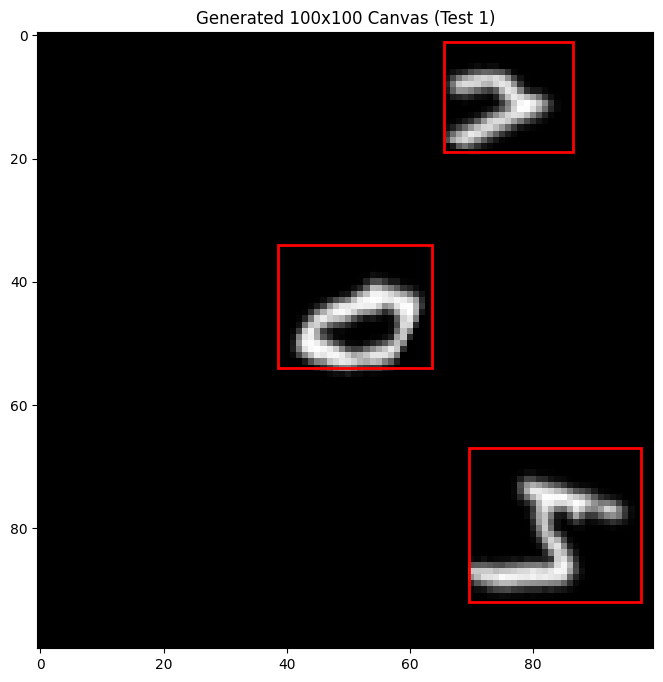

2025-11-07 11:31:17.968923: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Get one batch
# Your dataset is batched, so .take(1) gets one full batch
for batch in tf_processed_dataset.take(1):
    # Your map function returns (canvas, bboxes, labels)
    # So, 'batch' is a tuple of (batched_canvases, batched_bboxes, batched_labels)
    batched_canvases,predictions = batch
    print(f"batched_canvases shape: {batched_canvases.shape}")
    print(f"predictions shape ", tf.shape(predictions))
    # Get the very first canvas from the batch (shape 100x100)
    # We use .numpy() to convert it from a EagerTensor to a NumPy array for plotting
    canvas_to_show = batched_canvases[0].numpy()
    print(f"Canvas shape: {canvas_to_show.shape}")
    
    # Plot it
    # --- Create a figure and axis ---
    fig, ax = plt.subplots(1, figsize=(8, 8))

    
    prediction = predictions[0]
    print(f"prediction shape : {prediction.shape}")
    ## get the 3 predictions
    for i in range(3):
        bbox = (prediction[i]).numpy() * 100
        
        # flag, x_center, y_center, width, height,
        flag = bbox[0]
        x_center = bbox[1]
        y_center = bbox[2]
        width = bbox[3]
        height = bbox[4]
        
        x_min = x_center - (width / 2)
        y_min = y_center - (width / 2)
        
        print("flag, x_center, y_center, width, height",flag, x_min, y_min, width, height,)

        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        
        ax.add_patch(rect)
    
    
    
    
    # Display the image
    ax.imshow(canvas_to_show, cmap='gray')
    
    
    plt.title("Generated 100x100 Canvas (Test 1)")
    plt.show()

In [10]:
for batch in tf_processed_dataset.take(1):
    # Your map function returns (canvas, bboxes, labels)
    # So, 'batch' is a tuple of (batched_canvases, batched_bboxes, batched_labels)
    batched_canvases,predictions = batch
    print(f"batched_canvases shape: {batched_canvases.shape}")
    print(f"predictions shape ", tf.shape(predictions))
    print(f"predictions {predictions[0,0]}")


batched_canvases shape: (32, 100, 100)
predictions shape  tf.Tensor([32  5 15], shape=(3,), dtype=int32)
predictions [1.    0.155 0.195 0.28  0.22  0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.   ]


2025-11-07 11:31:59.027207: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
